**Integrantes:**

**1.** Jorge Ignacio Morales

**2.** Juan David Ceballos

**3.** Laura Isabel Barrera

In [34]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/UDEA-Esp-Analitica-y-Ciencia-de-Datos/EACD-01-FUNDAMENTOS/master/init.py
import init; init.init(force_download=False); 

# Precios de Casas

El objetivo de este taller es realizar un análisis exploratorio de un dataset. El dataset no llega limpio, el proceso de limpieza se encuentra implementado. Después de este proceso de limpieza se debe llevar a cabo el análisis exploratorio.

In [35]:
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Entendiendo y limpiando el dataset

La descripcion de cada variable puede verse ejecutando la siguiente celda

In [36]:
!cat local/data/houseprices_description.txt

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

Ahora carguemos los datos y hagamos una breve exploración

In [37]:
df = pd.read_csv("local/data/houseprices.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Podemos ver que hay una gran cantidad de valores nulos en algunas de las variables. Alguien, algo despistado, podría sugerir simplemente eliminar esas variables; sin embargo, la descripción de las variables que observamos anteriormente, nos permite entender la razón de ser de estos valores nulos y tratarlos de una manera inteligente. Por ejemplo, consideremos la variable `PoolQC` la cual nos muestra únicamente 7 valores no nulos de los 1460 registros que tenemos en total. Su descripción dice:

```
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

```

Esta variable hace referencia a la calidad de la piscina en la casa y vemos que `NA` significa que no tiene piscina, lo cual posiblemente tiene mucho impacto en el precio de una casa (pregúntese, ¿estaría dispuesto a pagar más por una casa que tenga piscina?). Además, vemos que existe la variable `PoolArea`, la cual almacena el area de la piscina en $ft^2$, la cual no tiene valores nulos. Dado esto, los valores nulos de la variable `PoolQC` deben corresponder a casos en los que la variable `PoolArea` es cero; validemos esto.

In [39]:
num_total_nulls = df["PoolQC"].isna().sum()
num_nulls_when_poolarea_is_zero = df[df["PoolArea"] == 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_zero == num_total_nulls

In [40]:
num_nulls_when_poolarea_is_not_zero = df[df["PoolArea"] != 0]["PoolQC"].isna().sum()
assert num_nulls_when_poolarea_is_not_zero == 0

Concluimos que se cumple que todos los valores nulos de la variable `PoolQC` corresponden a casos en los que no hay piscina; por lo tanto, vamos a reemplzar los valores nulos por otro valor que podamos usar en nuestros modelos.

In [41]:
df["PoolQC"] = df["PoolQC"].fillna("NP")

Esta misma lógica debemos usarla a la hora de tratar el resto de las variables con valores nulos de este dataset. Escribiremos algún razonamiento addiconal únicamente cuando haga falta

In [42]:
num_total_nulls = df["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_zero = df[df["MiscVal"] == 0]["MiscFeature"].isna().sum()
num_nulls_when_miscval_is_not_zero = df[df["MiscVal"] != 0]["MiscFeature"].isna().sum()
assert num_nulls_when_miscval_is_zero == num_total_nulls
assert num_nulls_when_miscval_is_not_zero == 0
df["MiscFeature"] = df["MiscFeature"].fillna("No MF")

In [43]:
num_total_nulls = df["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_zero = df[df["Fireplaces"] == 0]["FireplaceQu"].isna().sum()
num_nulls_when_fireplaces_is_not_zero = df[df["Fireplaces"] != 0]["FireplaceQu"].isna().sum()
assert num_nulls_when_fireplaces_is_zero == num_total_nulls
assert num_nulls_when_fireplaces_is_not_zero == 0
df["FireplaceQu"] = df["FireplaceQu"].fillna("No FP")

In [44]:
num_area_zeros = (df["GarageArea"] == 0).sum()
num_cars_zeros = (df["GarageCars"] == 0).sum()
num_both_zeros = ((df["GarageArea"] == 0) & (df["GarageCars"] == 0.0)).sum()
assert num_both_zeros == num_area_zeros == num_cars_zeros
for colname in ["GarageType", "GarageFinish", "GarageQual", "GarageCond"]:
    num_total_nulls = df[colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)][colname].isna().sum()
    num_nulls_when_area_and_cars_capacity_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)][colname].isna().sum()
    assert num_total_nulls == num_nulls_when_area_and_cars_capacity_is_zero
    assert num_nulls_when_area_and_cars_capacity_is_not_zero == 0
    df[colname] = df[colname].fillna("No Ga")

Para la variable `GarageYrBlt` debemos ser más cuidadosos, ya que son números y no strings. Esta variable nos dice el año en que fue construido el garaje y, según lo visto con otras variables relacionadas al garage, los valores nulos corresponden a casos en los que no hay garage. En este caso, vamos a imputar esa variable con un año posterior a la fecha de venta. Esta aproximación podría no funcionar muy bien con modelos lineales, o cuando escalamos los datos, pero no se me ocurre otra!

In [45]:
num_total_nulls = df["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_zero = df[(df["GarageArea"] == 0.0) & (df["GarageCars"] == 0.0)]["GarageYrBlt"].isna().sum()
num_nulls_when_area_and_cars_is_not_zero = df[(df["GarageArea"] != 0.0) & (df["GarageCars"] != 0.0)]["GarageYrBlt"].isna().sum()
assert num_nulls_when_area_and_cars_is_zero == num_total_nulls
assert num_nulls_when_area_and_cars_is_not_zero == 0
df["GarageYrBlt"].where(~df["GarageYrBlt"].isna(), other=df["YrSold"] + 1, inplace=True)

`LotFrontage: Linear feet of street connected to property)`

Valores nulos en esta variable podrían ser ocasionados porque sencillamente no hay conexión de la calle a la propiedad, es decir, que esa longitud medida por esta variable es igual a 0. Podemos asumir que este es el caso únicamente si no hay otro 0 en los valores que ha tomado esta variable, de otra manera ¿por qué algunos tendrían 0 y otros nulos?

In [46]:
assert (df["LotFrontage"] == 0).sum() == 0
df["LotFrontage"].fillna(0, inplace=True)

In [47]:
df["Alley"].fillna("NA", inplace=True)
df["Fence"].fillna("NF", inplace=True)

```
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet
```

Una posibilidad es que los valores nulos de `MasVnrType` y `MasVnrArea` correspondan a casos en los que no hay "Masonry veneer" (chapa de albañilería). Esto sería en los casos en que la variable `MasVnrArea` sea 0, esto lo validaremos de la misma manera en que validamos con la variable `LotFrontage`.

In [48]:
assert (df["MasVnrArea"] == 0).sum() == df["MasVnrType"].isnull().sum()

AssertionError: ignored

Acá la situación es diferente, el error anterior nos dice que los casos para los cuales no tenemos área son distintos de los que el tipo es nulo, entonces nos toca inspeccionar más en detalle. Sabemos que hay 8 valores nulos en cada una de las dos variables, miremos si corresponden a los mismos registros:

In [50]:
np.logical_and(df["MasVnrType"].isnull().values, df["MasVnrArea"].isnull().values).sum()

8

En efecto, dado que hay 8 registros para los cuales las dos variables tienen valores nulos, podemos decir que son nulos en ambas partes. A falta de información, vamos a decidir eliminar esos registros por completo, no debe ser muy grave, pues apenas son 8 filas en todo el dataset.

In [51]:
df = df.dropna(subset=["MasVnrType", "MasVnrArea"])

Ahora miremos los valores de cada una

In [52]:
df["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [53]:
df["MasVnrArea"].value_counts()

0.0      861
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64

Acá podemos observar lo siguiente:
- Hay 864 registros con `MasVnrType="None"`
- Hay 861 registros con `MasVnrArea=0`

Eso quiere decir que hay algunos registros que deberían tener un área de 0 y no es así. Vamos a mirar en detalle cuáles son:

In [54]:
df[(df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
624,625,60,RL,80.0,10400,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,11,2006,WD,Normal,165150
773,774,20,RL,70.0,10150,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,7,2007,COD,Normal,114500
1230,1231,90,RL,0.0,18890,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,Gar2,8300,8,2007,WD,Normal,190000
1300,1301,60,RL,0.0,10762,Pave,NA,IR1,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,225000
1334,1335,160,RM,24.0,2368,Pave,NA,Reg,Lvl,AllPub,...,0,NP,NF,No MF,0,5,2009,WD,Normal,125000


**Francamente** yo no soy un experto en casas, por lo que no tengo forma de deducir a qué se debe esa incoherencia en los datos. Por lo anterior, simplemente voy a eliminar esas filas, ya que tengo dudas de la veracidad de esos datos.

In [55]:
df = df[~((df["MasVnrType"] == "None") & (df["MasVnrArea"] != 0.0))]

La variable `Electrical` tampoco nos ofrece una forma de recuperar esos valores nulos, por lo que también vamos a eliminar ese registro. Nótese que otra opción podría ser reemplazarlo con el valor más común en la misma variable, dado que esta es categórica. 

In [56]:
df.dropna(subset=["Electrical"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1446 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1446 non-null   int64  
 1   MSSubClass     1446 non-null   int64  
 2   MSZoning       1446 non-null   object 
 3   LotFrontage    1446 non-null   float64
 4   LotArea        1446 non-null   int64  
 5   Street         1446 non-null   object 
 6   Alley          1446 non-null   object 
 7   LotShape       1446 non-null   object 
 8   LandContour    1446 non-null   object 
 9   Utilities      1446 non-null   object 
 10  LotConfig      1446 non-null   object 
 11  LandSlope      1446 non-null   object 
 12  Neighborhood   1446 non-null   object 
 13  Condition1     1446 non-null   object 
 14  Condition2     1446 non-null   object 
 15  BldgType       1446 non-null   object 
 16  HouseStyle     1446 non-null   object 
 17  OverallQual    1446 non-null   int64  
 18  OverallC

Ahora miremos las variables relacionadas con el basement:

```

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

```

Dado que los valores nulos en varias de estas variables corresponden a `No Basement`, ahora miremos si los registros nulos en algunas corresponden a los registros nulos en todas. Primero, dado que ya hemos eliminado varios registros, vamos a ver cuántos valores nulos hay en esas variables.

In [58]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
    "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF"]
for c in colnames:
    print(f"{c} has {df[c].isnull().sum()} null values")

BsmtQual has 37 null values
BsmtCond has 37 null values
BsmtExposure has 38 null values
BsmtFinType1 has 37 null values
BsmtFinSF1 has 0 null values
BsmtFinType2 has 38 null values
BsmtFinSF2 has 0 null values
BsmtUnfSF has 0 null values
TotalBsmtSF has 0 null values


In [59]:
df["TotalBsmtSF"].value_counts()

0       37
864     35
672     17
912     14
1040    14
        ..
1581     1
707      1
611      1
1452     1
1542     1
Name: TotalBsmtSF, Length: 716, dtype: int64

Acá vemos que algunas tienen más variables nulas que otras, lo cual es confuso porque en cualquier caso los valores nulos deberían significar que no hay basement. En este caso vamos a reemplazar los valores en los que los valores nulos sean en todas las variables no numéricas pero los que sobren los eliminaremos.

In [60]:
colnames = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
cond = ~(df["BsmtQual"].isna() & df["BsmtCond"].isna() & df["BsmtExposure"].isna() & df["BsmtFinType1"].isna() & df["BsmtFinType2"].isna())
for c in colnames:
    df[c].where(cond, other="NB", inplace=True)

In [61]:
df.dropna(inplace=True)
print(f"Number of null values {df.isna().sum().sum()} in a dataframe of shape {df.shape}")

Number of null values 0 in a dataframe of shape (1444, 81)


## Análisis exploratorio de datos

En esta sección se dejarán preguntas que deben ser respondidas utilizando los datos.

**¿Qué tan viejas son las casas?**

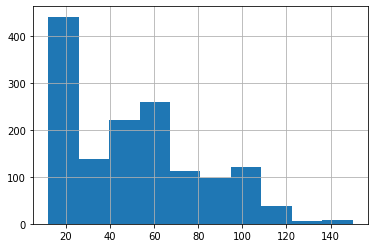

In [62]:
df["HouseAge"] = 2022 - df["YearBuilt"] # Se selecciona 2022 con el fin de calcular la antiguedad de las casa con respecto al año actual
df["HouseAge"].hist(bins=10)

In [63]:
descriptive_stats_analysis = (round(df.describe(),2))
descriptive_stats_analysis[["HouseAge"]]

,HouseAge
count,1444.00
mean,50.97
std,30.23
min,12.00
25%,22.00
50%,50.00
75%,68.25
max,150.00


El promedio de la edad de las casas esta al rededor de 51 años, sin embargo la mayor proporcion de casas tienen edades de hasta 25 años y existe un valor máximo de 150 años que sesga el calculo del promedio.

A continuación se muestra la distribución del total de casas del dataset comparando el año de construcción y la cantidad de casas construidas para ese daño: 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


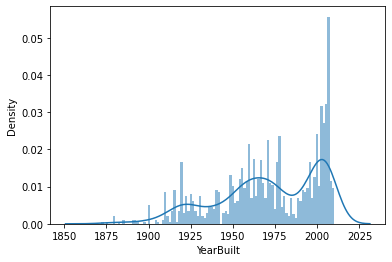

In [64]:
import seaborn as sns
sns.distplot(df["YearBuilt"],bins=100, hist_kws={"alpha":0.5})

De lo anterior podemos inferir que dentro del espacio muestral han habido 3 picos de construcción de casas propiamente en la primera decada de 1900, entre 1950 y 1975 y, finalmente en los 2000 que corresponde a la edad descrita anteriormente

**¿Cómo se relaciona el precio con la edad de la casa?**

Para calcular la relación entre las variables resulta práctico graficar parejas de puntos:

Text(0, 0.5, 'SalePrice')

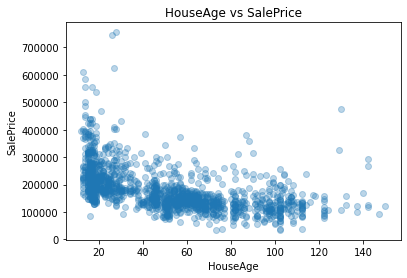

In [65]:
x = df["HouseAge"]
y = df["SalePrice"]
plt.scatter(x, y, alpha=0.3, cmap='viridis')
plt.title("HouseAge vs SalePrice")
plt.xlabel("HouseAge")
plt.ylabel("SalePrice")

In [66]:
df_corr_saleprice_and_houseage = df["HouseAge"].corr(df["SalePrice"])
df_corr_saleprice_and_houseage

-0.5227586142987865

Partiendo de la premisa que la correlación no implica causalidad, podemos deducir que existe una relación lineal inversamente proporcional; es posible concluir entonces que mientras mas antiguas son las casas el precio es mas bajo o sea que las casas más modernas tienden a ser más costosas.

Evidenciamos que la correlación es correspondiente con lo evidenciado en el grafico.

Si se evalua la correlación para las casas con una antiguedad mayor a 40 años, encontramos que la asociación lineal se debilita: **la correlación pasa de -0.52 a -0.17**

```
x = df[df["HouseAge"]>40]["HouseAge"]
y = df[df["HouseAge"]>40]["SalePrice"]

correlacion_ = x.corr(y)
print(correlacion_)

plt.scatter(x, y, alpha=0.3, cmap='viridis')
```



**¿Cuál es el barrio más pobre?**

Para determinar cuál es el barrio más pobre se utiliza un gráfico en el que se pueda ver la distribución de los datos para la variable en cuestión:

[Text(0.5, 1.0, 'Houses Per Neighborhood and their Price distribution')]

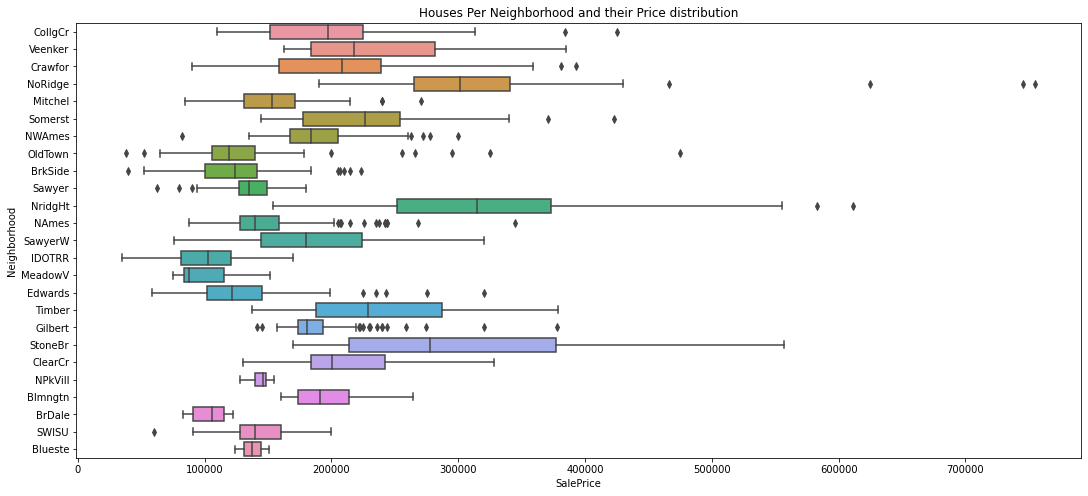

In [82]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,8))
sns.boxplot(y = df["Neighborhood"],
            x = df["SalePrice"]).set(title='Houses Per Neighborhood and their Price distribution')


A continuación se relacionan otras variables que podrían aportar valor al barrio y por ender generar una idea de qué barrio carece de ciertos atributos

In [68]:
df[["Neighborhood","SalePrice","HouseAge","Fireplaces","GarageArea","TotalBsmtSF","LotArea"]].groupby('Neighborhood').mean().sort_values(["SalePrice"],ascending=True)

,SalePrice,HouseAge,Fireplaces,GarageArea,TotalBsmtSF,LotArea
Neighborhood,,,,,,
MeadowV,98576.470588,49.411765,0.352941,259.470588,653.352941,2324.000000
IDOTRR,100123.783784,94.054054,0.216216,316.000000,746.837838,8109.162162
BrDale,103126.666667,50.466667,0.066667,273.600000,571.800000,1763.200000
BrkSide,124834.051724,90.568966,0.431034,303.241379,765.413793,7360.413793
Edwards,128219.700000,66.030000,0.320000,326.200000,899.820000,10218.650000
OldTown,128225.300885,99.115044,0.336283,382.123894,810.230088,8207.061947
Sawyer,136064.273973,58.506849,0.438356,392.589041,962.041096,10343.794521
Blueste,137500.000000,42.000000,1.000000,457.000000,638.500000,1625.000000
SWISU,142591.360000,96.760000,0.600000,281.600000,847.080000,8127.560000


Se concluye que el barrio mas pobre es "MeadowV" ya que el promedio del precio de las casas es el mas bajo entre los barios, además el promedio de area construida, de basemant y de garages es uno de los mas bajos también.

Así como se determina el uso de x o y variables en la construcción de un cálculo también es posible abordar la pregunta a través de otras medidas estadísticas diferentes al promedio:
```
df.groupby('Neighborhood', as_index=True)['SalePrice'].median()
```
Validando con la medidana se ha encontrado que MeadowV sigue posicionado por debajo de los datos.

Finalmente otra medida propuesta es crear una métrica propia por ejemplo: 

```
df['TotalLivingSF'] = df['GrLivArea'] + df['TotalBsmtSF']
df.groupby('Neighborhood', as_index=True)['SalePrice'].mean()  / df.groupby('Neighborhood', as_index=True)['TotalLivingSF'].mean()
```

Ejecutando el código anterior se obtiene que de la relación del precio de la casa y sus metros cuadrados, otro de los barrios más pobres es IDOTRR siendo que con este mismo análisis SWISU, OldTown y MeadowV se comportan de manera similar.



**¿Cuál es el barrio más cercano a vías férreas?**

Para determinar lo anterior se utilizado el método de crear variables dummy para transformar varaibles cualitativas a discretas y dichas variables fueron las que almacenaban la información relacionada a RailRoads

In [69]:
df_rr = pd.concat([df[['Neighborhood']],pd.get_dummies(df[['Condition1', 'Condition2']],prefix='Cond')], axis=1).groupby("Neighborhood").sum()
frr_arr = df_rr.filter(like='RR',axis=1)
frr_arr
# Ideal darle un peso proporcional a las columnas An mayor a las Nn para poder sacar la proporcion

,Cond_RRAe,Cond_RRAn,Cond_RRNe,Cond_RRNn,Cond_RRAn,Cond_RRNn
Neighborhood,,,,,,
Blmngtn,0,0,0,0,0,0
Blueste,0,0,0,0,0,0
BrDale,0,0,0,0,0,0
BrkSide,0,7,0,1,0,1
ClearCr,0,0,0,0,0,0
CollgCr,0,0,0,0,0,0
Crawfor,0,0,0,0,0,0
Edwards,0,0,0,0,0,0
Gilbert,0,8,0,1,0,0


De la información anterior y, a través de un conteo en el cual se tuvo en cuenta la cantidad de casas (vendidas) cercanas a vías ferreas se concluye que, **Gilbert** es el barrio con casas más cercanas a vías férreas. Se destaca también el barrio **BrkSide** que presenta igual cantidad de casas cercanas a las vias ferreas sin embargo es **Gilbert en donde están mas adyacentes**.

**¿Cuál es la cobertura más común en las casas que se encuentran el el top 10% en precio?**

Para responder a la pregunta se obtiene el 10% de los datos de las casas más costosas mientras, a su vez, se obtienen las variables Exterior quienes aportan la información sobre cobertura: 

In [91]:
df_filter_price = df[['SalePrice','Exterior1st','Exterior2nd']].sort_values(by=['SalePrice'] ,ascending=False).head(round(len(df.index)*0.1))
print(len(df_filter_price))
df_filter_price[['Exterior1st','Exterior2nd']].value_counts()

#f_dummies_exterior = pd.get_dummies(df_filter_price,prefix='ext')
#df_dummies_exterior.value_counts()
#a = df_dummies_exterior.groupby(axis=1,by=[df_dummies_exterior.keys()]).sum()
#print(a)
# Se debe hacer distinct de las tipologias, se suman las columnas y se escoge el mayor

144


Exterior1st  Exterior2nd
VinylSd      VinylSd        83
CemntBd      CmentBd        18
MetalSd      MetalSd         9
Wd Sdng      Wd Sdng         6
BrkFace      BrkFace         5
HdBoard      HdBoard         5
Plywood      Plywood         4
Wd Sdng      ImStucc         2
WdShing      Wd Shng         2
BrkFace      Wd Sdng         2
             HdBoard         1
Stucco       CmentBd         1
             Stucco          1
VinylSd      ImStucc         1
             Other           1
Plywood      Wd Sdng         1
CemntBd      Wd Shng         1
Stone        HdBoard         1
dtype: int64

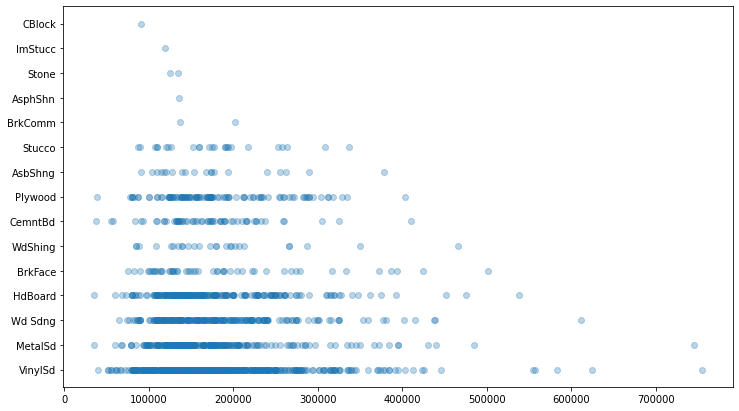

In [103]:
plt.figure(figsize = (12,7))

x = df["SalePrice"].nlargest(n=len(df)*10)
y = df["Exterior1st"]
plt.scatter(x, y, alpha=0.3, cmap='brown')
plt.show()




La cobertura mas común entre las casas es "VinySd", ya que la relacion es mayor cuando observamosesta categoría. Además la concentración de parejas de puntos, nos da un indicio de que la frecuencia es mayor.

**¿En qué barrio hay mayor desigualdad?**

Se relacionan variables que generan valor tales como:
```
["Neighborhood","SalePrice","HouseAge","Fireplaces","GarageArea","TotalBsmtSF","LotArea",'PoolArea']
```
A cada una de éstas se les ha calculado la desviación estándar para tener una idea sobre la dispersión de los datos. 
Posteriormente se aplican poderaciones para determinar la participación de cada variable y, finalmente basados en la suma de los ponderadores mostrar un orden en los barrios de acuerdo a su total(score).

In [ ]:
neighborhood_std = df[["Neighborhood","SalePrice","HouseAge","Fireplaces","GarageArea","TotalBsmtSF","LotArea",'PoolArea']].groupby('Neighborhood').std().sort_values(["SalePrice"],ascending=True)

sum_columns = neighborhood_std.agg("sum")

neighborhood_std_percentage = neighborhood_std.apply(lambda x: (x/sum_columns[x.name])*100)
neighborhood_std_percentage = neighborhood_std.apply(lambda x: (x/sum_columns[x.name])*100).agg('sum',axis=1).sort_values(ascending = False)
neighborhood_std_percentage

Se concluye que el barrio con mayor desigualdad es Edwards el cual luego de haber incluido la variable "PoolArea" presentó mayor variación y score. Sin embargo barrio como Timber y NoRidge podrían considerarse similares en desigualdad esto como medida de considerar o no más o menos variables.

Otros calculos podrían ser: 
```
x = df["SalePrice"]
y = df["OverallQual"]

correlacion_ = x.corr(y)
print(correlacion_)

plt.scatter(x, y, alpha=0.3, cmap='viridis')
```

Los cuales muestran una correlación de 0.79 entre el Precio de Venta y la Calificación de la casa.

**¿En qué año hubo más movimiento del mercado inmobiliario?**

In [ ]:
df[['YrSold','SalePrice']].groupby("YrSold").agg(Total_Year=('YrSold', 'count'), Price_Year=('SalePrice', 'sum'))

Analizando el movimiento del mercado por la totalidad de ventas realizadas en cada año, en **2009 fue cuando se registraron el mayor número de venta de casas: 334**, de hecho esto coincide con la crisis de la burbuja inmobiliaria originada en 2008. 
Basados en la variable Precio, fue **2007 el año en que más dinero se movió en el mercado inmobiliario con US$60,5M**.

**¿Cuáles son los 2 barrios con mayor industria cerca?**

In [ ]:
df['MSZoning'].value_counts()

In [ ]:
df[['Neighborhood','MSZoning']][df['MSZoning'] == "I"].groupby("Neighborhood").count()

Teniendo en cuenta las categorías de los sectores aledaños a cada barrio, basados MSZoning no se encuentra registro del sector Industria por lo cual no podemos identificar cuales tienen industria cerca. Sin embargo una idea podría ser graficar cada barrio dentro del mapa de la ciudad a cual pertenecen y una vez allí identificar las industrias y sus distancias.

**¿Cuáles son los 2 barrios con mayor comercio cerca?**

In [ ]:
df[['Neighborhood','MSZoning']][df['MSZoning'] == "C (all)"].groupby("Neighborhood").count()

En la zona Comercial, con base en la columna MSZoning, se identifica que los barrios que se encuentran alli son IDOTRR y OldTown